Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - binary_accuracy: 0.5002 - loss: 0.6936 - val_binary_accuracy: 0.5200 - val_loss: 0.6924
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_accuracy: 0.5421 - loss: 0.6903 - val_binary_accuracy: 0.5379 - val_loss: 0.6909
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - binary_accuracy: 0.5675 - loss: 0.6873 - val_binary_accuracy: 0.5647 - val_loss: 0.6885
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_accuracy: 0.6033 - loss: 0.6833 - val_binary_accuracy: 0.5962 - val_loss: 0.6846
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_accuracy: 0.6602 - loss: 0.6766 - val_binary_accuracy: 0.6294 - val_loss: 0.6782
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_accuracy: 0.6971 - loss: 0.6693 - val_binary_accuracy: 0.6673 - val_loss: 0.6684
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_accuracy: 0.7356 - loss: 0.6568 - val_binary_accuracy: 0.7081 - val_loss: 0.6542
Epoch 8/10
40/40 ━━

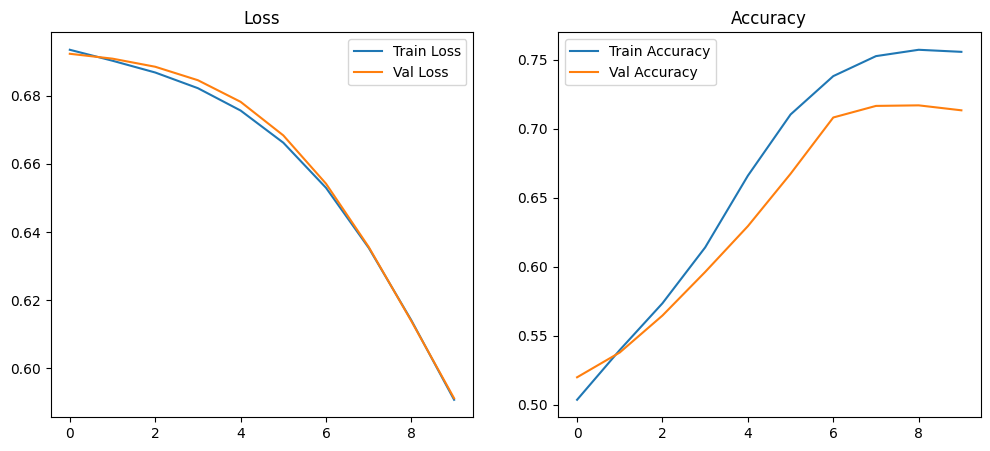

Recommendations for basket: ['whole milk', 'rolls/buns']
['white bread', 'curd', 'domestic eggs', 'cream cheese ', 'white wine']


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from itertools import combinations
import matplotlib.pyplot as plt

# 1. Load and preprocess data
df = pd.read_csv('../data/Groceries_cleaned_dataset2.csv')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

# Group by basket: (user, date) -> list of items bought together
baskets = df.groupby(['Member_number', 'Date'])['itemDescription'].apply(list).reset_index()

# Create item2idx and idx2item mappings
all_items = df['itemDescription'].unique()
item2idx = {item: i for i, item in enumerate(all_items)}
idx2item = {i: item for item, i in item2idx.items()}
num_items = len(all_items)

# 2. Generate positive item pairs from baskets
positive_pairs = []
for items in baskets['itemDescription']:
    unique_items = sorted(set(items))
    if len(unique_items) > 1:
        positive_pairs.extend(combinations(unique_items, 2))

positive_pairs = list(set(positive_pairs))
positive_pairs_idx = [(item2idx[i1], item2idx[i2]) for i1, i2 in positive_pairs]

# Positive samples: label=1
pos_samples = [(i, j, 1) for i, j in positive_pairs_idx]

# 3. Generate negative samples: pairs NOT co-occurring
positive_set = set(positive_pairs_idx)
negative_samples = []
while len(negative_samples) < len(pos_samples):
    i = np.random.randint(num_items)
    j = np.random.randint(num_items)
    if i != j and (i, j) not in positive_set and (j, i) not in positive_set:
        negative_samples.append((i, j, 0))

# Combine and shuffle samples
all_samples = pos_samples + negative_samples
np.random.shuffle(all_samples)

samples_df = pd.DataFrame(all_samples, columns=['item1', 'item2', 'label'])

# Train-test split
train_df, test_df = train_test_split(samples_df, test_size=0.2, random_state=42)

# 4. Prepare TensorFlow datasets
def df_to_tf_dataset(df):
    ds = tf.data.Dataset.from_tensor_slices((
        {"item1": df['item1'].values, "item2": df['item2'].values},
        df['label'].values
    ))
    return ds.shuffle(10000).batch(256).prefetch(tf.data.AUTOTUNE)

train_ds = df_to_tf_dataset(train_df)
test_ds = df_to_tf_dataset(test_df)

# 5. Define item-item embedding model
class ItemItemModel(tf.keras.Model):
    def __init__(self, num_items, embedding_dim=32):
        super().__init__()
        self.item_emb = tf.keras.layers.Embedding(num_items, embedding_dim,
                                                  embeddings_initializer='he_normal',
                                                  embeddings_regularizer=tf.keras.regularizers.l2(1e-6))
    def call(self, inputs):
        emb1 = self.item_emb(inputs['item1'])
        emb2 = self.item_emb(inputs['item2'])
        dot = tf.reduce_sum(emb1 * emb2, axis=1)
        return tf.nn.sigmoid(dot)

model = ItemItemModel(num_items)

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.BinaryAccuracy()]
)

# 6. Train model and save history
history = model.fit(train_ds, epochs=10, validation_data=test_ds)

# 7. Plot training curves
def plot_training(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['binary_accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_binary_accuracy'], label='Val Accuracy')
    plt.title('Accuracy')
    plt.legend()

    plt.show()

plot_training(history)

# 8. Recommend items for a basket (list of item names)
def recommend_items(basket, top_k=5):
    basket_idxs = [item2idx[i] for i in basket if i in item2idx]
    if not basket_idxs:
        print("No known items in basket.")
        return []

    # Compute similarity score for all items by averaging predicted probability with basket items
    scores = np.zeros(num_items)
    for item_idx in range(num_items):
        # Avoid recommending items already in basket
        if item_idx in basket_idxs:
            scores[item_idx] = -1  # exclude self

        else:
            pairs = {
                "item1": np.array([item_idx]*len(basket_idxs)),
                "item2": np.array(basket_idxs)
            }
            preds = model(pairs).numpy()
            scores[item_idx] = preds.mean()

    # Get top-k items with highest similarity
    top_items_idx = np.argsort(scores)[-top_k:][::-1]
    recommendations = [idx2item[i] for i in top_items_idx]
    return recommendations

# Example usage:
user_basket = ["whole milk", "rolls/buns"]
print("Recommendations for basket:", user_basket)
print(recommend_items(user_basket, top_k=5))




Probability that user 1959 will purchase 'frankfurter': 0.2154
